In [100]:
!pip install umap-learn

In [152]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, f1_score, r2_score
from math import sqrt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import shap

In [3]:
def correlation_matrix(self) -> None:    # Строит стандартную корреляционную матрицу
    plt.subplots(figsize=(10, 8))
    sns.heatmap(self.corr(), cmap='RdBu', annot=True, fmt=".2f", annot_kws={"size": 10, "ha": "center", "va": "center"})
    plt.xticks(range(len(self.corr().columns)), self.corr().columns);
    plt.yticks(range(len(self.corr().columns)), self.corr().columns)
    plt.title("Корреляционная матрица", fontsize=16)
    plt.show()

def top_correlations(self, top_n: int) -> None:        # Выводит top_n корреляционных пар
    correlation_matrix = self.corr()
    correlation_pairs = correlation_matrix.unstack()
    correlation_pairs = correlation_pairs.reset_index()
    correlation_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']
    correlation_pairs = correlation_pairs[correlation_pairs['Variable 1'] != correlation_pairs['Variable 2']]
    correlation_pairs['Ordered Pair'] = correlation_pairs.apply(lambda x: tuple(sorted([x['Variable 1'], x['Variable 2']])), axis='columns')
    correlation_pairs = correlation_pairs.drop_duplicates(subset=['Ordered Pair'])
    correlation_pairs['Abs Correlation'] = correlation_pairs['Correlation'].abs()
    top_correlations = correlation_pairs.sort_values(by='Abs Correlation', ascending=False)
    for i in range(top_n):
      row = top_correlations.iloc[i]
      print(f"{i + 1}. {row['Variable 1']} AND {row['Variable 2']}: {row['Correlation']:.2f}")

def top_correlations_to_parametr(self, top_n: int, num_column: int) -> None:  # Выводит top_n корреляционных пар с привязкой к to_column
    correlation_matrix = self.corr()
    to_column = self.columns[num_column]
    correlation_pairs = correlation_matrix[[to_column]].reset_index()
    correlation_pairs.columns = ['Variable', 'Correlation']
    correlation_pairs = correlation_pairs[correlation_pairs['Variable'] != to_column]
    correlation_pairs['Abs Correlation'] = correlation_pairs['Correlation'].abs()
    top_correlations = correlation_pairs.sort_values(by='Abs Correlation', ascending=False)
    for i in range(min(top_n, len(top_correlations))):
        row = top_correlations.iloc[i]
        print(f"{i + 1}. {row['Variable']} AND {to_column}: {row['Correlation']:.2f}")

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loan Data

In [5]:
df = pd.read_csv('/content/drive/MyDrive/loan_data.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [6]:
df = pd.DataFrame(df)
for column in df.select_dtypes(include=['object']).columns:
    df[column], unique = pd.factorize(df[column])

In [ ]:
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,0,0,71948.0,0,0,35000.0,0,16.02,0.49,3.0,561,0,1
1,21.0,0,1,12282.0,0,1,1000.0,1,11.14,0.08,2.0,504,1,0
2,25.0,0,1,12438.0,3,2,5500.0,2,12.87,0.44,3.0,635,0,1
3,23.0,0,2,79753.0,0,0,35000.0,2,15.23,0.44,2.0,675,0,1
4,24.0,1,0,66135.0,1,0,35000.0,2,14.27,0.53,4.0,586,0,1


In [82]:
X = df.drop('loan_status', axis=1)
y = df['loan_status'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=3, stratify=y)

scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.fit_transform(X_test)

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

X_train_normpd = pd.DataFrame(X_train_norm, columns=X.columns)
X_test_normpd = pd.DataFrame(X_test_norm, columns=X.columns)

## shap

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='relu')])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='mse',
              metrics=['mse'])

early_stopping = EarlyStopping(monitor='val_mse', patience=50, restore_best_weights=True)

history = model.fit(X_train_normpd,
                    y_train,
                    batch_size=64,
                    epochs=60,
                    validation_data=(X_test_normpd, y_test),
                    callbacks=[early_stopping])

Epoch 1/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1405 - mse: 0.1405 - val_loss: 0.0745 - val_mse: 0.0745
Epoch 2/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0853 - mse: 0.0853 - val_loss: 0.0725 - val_mse: 0.0725
Epoch 3/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0802 - mse: 0.0802 - val_loss: 0.0715 - val_mse: 0.0715
Epoch 4/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0809 - mse: 0.0809 - val_loss: 0.0704 - val_mse: 0.0704
Epoch 5/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0768 - mse: 0.0768 - val_loss: 0.0703 - val_mse: 0.0703
Epoch 6/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0758 - mse: 0.0758 - val_loss: 0.0697 - val_mse: 0.0697
Epoch 7/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0755 - mse: 0.0755 - val_loss: 0.0694 - val_mse: 0.0694
Epoch 8/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0746 - mse: 0.0746 - val_loss: 0.0695 - val_mse: 0.0695
Epoch 9/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - lo

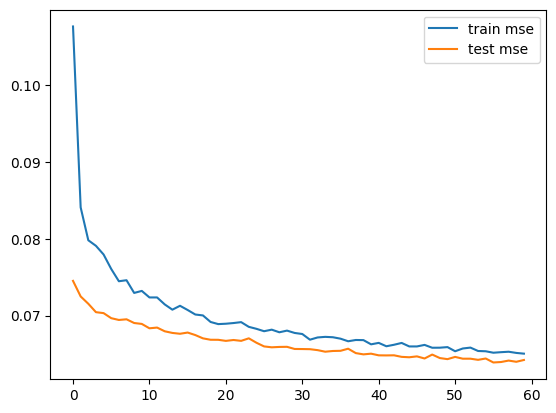

In [ ]:
plt.plot(history.history['mse'], label='train mse')
plt.plot(history.history['val_mse'], label='test mse')
plt.legend();

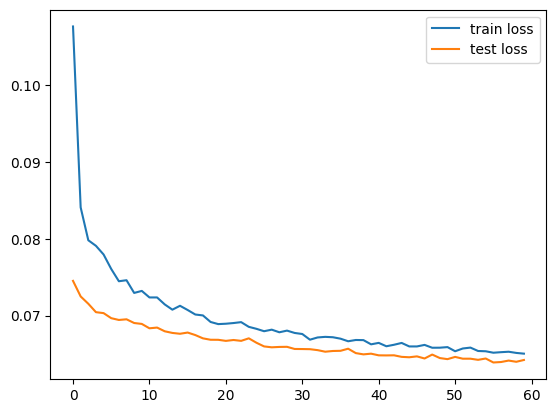

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend();

In [ ]:
explainer = shap.Explainer(model.predict, X_train_normpd[:300])
shap_values = explainer(X_test_normpd[:300])

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━

PermutationExplainer explainer:   1%|          | 2/300 [00:00<?, ?it/s]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   1%|▏         | 4/300 [00:18<16:10,  3.28s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:   2%|▏         | 5/300 [00:23<19:34,  3.98s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   2%|▏         | 6/300 [00:28<23:05,  4.71s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:   2%|▏         | 7/300 [00:33<22:48,  4.67s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:   3%|▎         | 8/300 [00:37<22:16,  4.58s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:   3%|▎         | 9/300 [00:43<24:29,  5.05s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:   3%|▎         | 10/300 [00:48<23:43,  4.91s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   4%|▎         | 11/300 [00:54<24:36,  5.11s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:   4%|▍         | 12/300 [00:59<25:36,  5.34s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:   4%|▍         | 13/300 [01:04<24:55,  5.21s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:   5%|▍         | 14/300 [01:10<26:01,  5.46s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:   5%|▌         | 15/300 [01:16<25:37,  5.40s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   5%|▌         | 16/300 [01:21<25:46,  5.45s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   6%|▌         | 17/300 [01:27<26:24,  5.60s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:   6%|▌         | 18/300 [01:33<25:57,  5.52s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:   6%|▋         | 19/300 [01:39<26:35,  5.68s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   7%|▋         | 20/300 [01:44<25:50,  5.54s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   7%|▋         | 21/300 [01:50<26:22,  5.67s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:   7%|▋         | 22/300 [01:54<24:47,  5.35s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   8%|▊         | 23/300 [01:59<24:13,  5.25s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:   8%|▊         | 24/300 [02:05<25:07,  5.46s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   8%|▊         | 25/300 [02:10<24:29,  5.34s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   9%|▊         | 26/300 [02:16<24:41,  5.41s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:   9%|▉         | 27/300 [02:21<24:17,  5.34s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:   9%|▉         | 28/300 [02:26<22:54,  5.05s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  10%|▉         | 29/300 [02:32<24:04,  5.33s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  10%|█         | 30/300 [02:36<23:04,  5.13s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  10%|█         | 31/300 [02:41<23:01,  5.14s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  11%|█         | 32/300 [02:48<24:34,  5.50s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


PermutationExplainer explainer:  11%|█         | 33/300 [02:58<31:01,  6.97s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  11%|█▏        | 34/300 [03:04<29:37,  6.68s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  12%|█▏        | 35/300 [03:09<27:32,  6.24s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  12%|█▏        | 36/300 [03:16<27:50,  6.33s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  12%|█▏        | 37/300 [03:21<25:50,  5.89s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  13%|█▎        | 38/300 [03:27<25:41,  5.88s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  13%|█▎        | 39/300 [03:32<25:16,  5.81s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  13%|█▎        | 40/300 [03:37<23:56,  5.52s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  14%|█▎        | 41/300 [03:43<23:51,  5.53s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  14%|█▍        | 42/300 [03:48<23:20,  5.43s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  14%|█▍        | 43/300 [03:54<24:46,  5.78s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  15%|█▍        | 44/300 [04:00<23:46,  5.57s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  15%|█▌        | 45/300 [04:06<24:17,  5.72s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  15%|█▌        | 46/300 [04:11<23:54,  5.65s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  16%|█▌        | 47/300 [04:16<22:52,  5.43s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  16%|█▌        | 48/300 [04:22<23:49,  5.67s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  16%|█▋        | 49/300 [04:28<23:37,  5.65s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  17%|█▋        | 50/300 [04:33<23:17,  5.59s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  17%|█▋        | 51/300 [04:39<23:46,  5.73s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  17%|█▋        | 52/300 [04:44<22:59,  5.56s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  18%|█▊        | 53/300 [04:51<23:45,  5.77s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  18%|█▊        | 54/300 [04:56<22:26,  5.47s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  18%|█▊        | 55/300 [05:02<23:19,  5.71s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  19%|█▊        | 56/300 [05:07<22:39,  5.57s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  19%|█▉        | 57/300 [05:12<22:20,  5.52s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  19%|█▉        | 58/300 [05:19<23:00,  5.70s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  20%|█▉        | 59/300 [05:23<21:58,  5.47s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  20%|██        | 60/300 [05:30<22:55,  5.73s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  20%|██        | 61/300 [05:36<22:49,  5.73s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  21%|██        | 62/300 [05:42<23:52,  6.02s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  21%|██        | 63/300 [05:48<23:57,  6.07s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  21%|██▏       | 64/300 [05:54<23:09,  5.89s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  22%|██▏       | 65/300 [06:00<23:00,  5.87s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  22%|██▏       | 66/300 [06:05<21:54,  5.62s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  22%|██▏       | 67/300 [06:11<22:32,  5.80s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  23%|██▎       | 68/300 [06:15<20:56,  5.42s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  23%|██▎       | 69/300 [06:20<20:19,  5.28s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  23%|██▎       | 70/300 [06:27<21:35,  5.63s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  24%|██▎       | 71/300 [06:32<20:23,  5.34s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  24%|██▍       | 72/300 [06:38<21:08,  5.56s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  24%|██▍       | 73/300 [06:43<20:50,  5.51s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  25%|██▍       | 74/300 [06:49<20:43,  5.50s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  25%|██▌       | 75/300 [06:55<21:11,  5.65s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  25%|██▌       | 76/300 [07:00<20:38,  5.53s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  26%|██▌       | 77/300 [07:06<21:27,  5.77s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  26%|██▌       | 78/300 [07:12<21:11,  5.73s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  26%|██▋       | 79/300 [07:17<20:58,  5.69s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  27%|██▋       | 80/300 [07:23<20:24,  5.57s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  27%|██▋       | 81/300 [07:28<20:22,  5.58s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  27%|██▋       | 82/300 [07:34<20:55,  5.76s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  28%|██▊       | 83/300 [07:40<20:22,  5.63s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  28%|██▊       | 84/300 [07:46<20:42,  5.75s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  28%|██▊       | 85/300 [07:51<20:04,  5.60s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  29%|██▊       | 86/300 [07:56<19:10,  5.38s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  29%|██▉       | 87/300 [08:02<20:05,  5.66s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  29%|██▉       | 88/300 [08:07<19:04,  5.40s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  30%|██▉       | 89/300 [08:13<19:26,  5.53s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  30%|███       | 90/300 [08:18<19:03,  5.44s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  30%|███       | 91/300 [08:23<18:28,  5.30s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  31%|███       | 92/300 [08:29<19:02,  5.49s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  31%|███       | 93/300 [08:34<18:40,  5.41s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  31%|███▏      | 94/300 [08:39<18:28,  5.38s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  32%|███▏      | 95/300 [08:45<18:55,  5.54s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  32%|███▏      | 96/300 [08:50<18:18,  5.38s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  32%|███▏      | 97/300 [08:57<18:55,  5.59s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  33%|███▎      | 98/300 [09:02<18:19,  5.44s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  33%|███▎      | 99/300 [09:07<18:25,  5.50s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  33%|███▎      | 100/300 [09:13<18:27,  5.54s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  34%|███▎      | 101/300 [09:18<18:18,  5.52s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  34%|███▍      | 102/300 [09:25<18:54,  5.73s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  34%|███▍      | 103/300 [09:30<18:39,  5.68s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  35%|███▍      | 104/300 [09:36<19:13,  5.89s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  35%|███▌      | 105/300 [09:42<18:37,  5.73s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  35%|███▌      | 106/300 [09:47<17:57,  5.56s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  36%|███▌      | 107/300 [09:53<18:23,  5.72s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  36%|███▌      | 108/300 [09:58<17:20,  5.42s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  36%|███▋      | 109/300 [10:05<19:04,  5.99s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  37%|███▋      | 110/300 [10:11<18:47,  5.93s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  37%|███▋      | 111/300 [10:16<17:50,  5.66s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  37%|███▋      | 112/300 [10:22<18:17,  5.84s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  38%|███▊      | 113/300 [10:28<17:54,  5.74s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  38%|███▊      | 114/300 [10:34<18:05,  5.83s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  38%|███▊      | 115/300 [10:39<17:18,  5.61s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  39%|███▊      | 116/300 [10:44<16:40,  5.44s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  39%|███▉      | 117/300 [10:51<18:01,  5.91s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  39%|███▉      | 118/300 [10:56<17:24,  5.74s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  40%|███▉      | 119/300 [11:03<17:49,  5.91s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  40%|████      | 120/300 [11:08<16:52,  5.62s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  40%|████      | 121/300 [11:13<17:03,  5.72s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  41%|████      | 122/300 [11:19<17:00,  5.73s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  41%|████      | 123/300 [11:24<16:24,  5.56s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  41%|████▏     | 124/300 [11:30<16:44,  5.71s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  42%|████▏     | 125/300 [11:36<16:18,  5.59s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  42%|████▏     | 126/300 [11:41<16:09,  5.57s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  42%|████▏     | 127/300 [11:47<16:27,  5.71s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  43%|████▎     | 128/300 [11:53<16:16,  5.68s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  43%|████▎     | 129/300 [11:59<16:51,  5.91s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  43%|████▎     | 130/300 [12:05<16:37,  5.86s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  44%|████▎     | 131/300 [12:12<17:01,  6.04s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  44%|████▍     | 132/300 [12:17<16:06,  5.75s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  44%|████▍     | 133/300 [12:23<16:23,  5.89s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  45%|████▍     | 134/300 [12:29<16:20,  5.91s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  45%|████▌     | 135/300 [12:33<15:11,  5.52s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  45%|████▌     | 136/300 [12:40<15:53,  5.82s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  46%|████▌     | 137/300 [12:45<15:32,  5.72s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  46%|████▌     | 138/300 [12:52<15:55,  5.90s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  46%|████▋     | 139/300 [12:57<15:29,  5.78s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  47%|████▋     | 140/300 [13:02<14:56,  5.60s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  47%|████▋     | 141/300 [13:09<15:38,  5.90s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  47%|████▋     | 142/300 [13:14<15:06,  5.74s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  48%|████▊     | 143/300 [13:21<15:38,  5.98s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  48%|████▊     | 144/300 [13:27<15:21,  5.90s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  48%|████▊     | 145/300 [13:33<15:38,  6.05s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  49%|████▊     | 146/300 [13:39<15:16,  5.95s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  49%|████▉     | 147/300 [13:44<14:47,  5.80s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  49%|████▉     | 148/300 [13:50<14:45,  5.83s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  50%|████▉     | 149/300 [13:56<14:23,  5.72s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  50%|█████     | 150/300 [14:02<14:52,  5.95s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  50%|█████     | 151/300 [14:07<14:08,  5.70s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  51%|█████     | 152/300 [14:13<13:46,  5.58s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  51%|█████     | 153/300 [14:19<14:30,  5.92s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  51%|█████▏    | 154/300 [14:25<14:18,  5.88s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  52%|█████▏    | 155/300 [14:32<14:53,  6.16s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  52%|█████▏    | 156/300 [14:37<14:12,  5.92s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  52%|█████▏    | 157/300 [14:44<14:36,  6.13s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  53%|█████▎    | 158/300 [14:50<14:25,  6.10s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  53%|█████▎    | 159/300 [14:55<13:47,  5.87s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  53%|█████▎    | 160/300 [15:02<14:01,  6.01s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  54%|█████▎    | 161/300 [15:07<13:33,  5.85s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  54%|█████▍    | 162/300 [15:14<13:58,  6.07s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  54%|█████▍    | 163/300 [15:19<13:36,  5.96s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  55%|█████▍    | 164/300 [15:26<13:44,  6.06s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  55%|█████▌    | 165/300 [15:32<13:48,  6.14s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  55%|█████▌    | 166/300 [15:38<13:33,  6.07s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  56%|█████▌    | 167/300 [15:44<13:33,  6.11s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  56%|█████▌    | 168/300 [15:50<13:04,  5.94s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  56%|█████▋    | 169/300 [15:56<13:11,  6.04s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  57%|█████▋    | 170/300 [16:02<12:54,  5.95s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  57%|█████▋    | 171/300 [16:08<12:54,  6.00s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  57%|█████▋    | 172/300 [16:14<12:54,  6.05s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  58%|█████▊    | 173/300 [16:20<12:49,  6.06s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  58%|█████▊    | 174/300 [16:26<12:47,  6.10s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  58%|█████▊    | 175/300 [16:32<12:32,  6.02s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  59%|█████▊    | 176/300 [16:39<12:48,  6.20s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  59%|█████▉    | 177/300 [16:44<12:11,  5.94s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  59%|█████▉    | 178/300 [16:51<12:28,  6.14s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  60%|█████▉    | 179/300 [16:56<12:09,  6.03s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  60%|██████    | 180/300 [17:03<12:21,  6.18s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  60%|██████    | 181/300 [17:09<12:14,  6.18s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  61%|██████    | 182/300 [17:15<11:57,  6.08s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  61%|██████    | 183/300 [17:22<12:11,  6.26s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  61%|██████▏   | 184/300 [17:27<11:49,  6.11s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  62%|██████▏   | 185/300 [17:34<12:07,  6.33s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  62%|██████▏   | 186/300 [17:40<11:36,  6.11s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  62%|██████▏   | 187/300 [17:46<11:31,  6.12s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  63%|██████▎   | 188/300 [17:51<11:07,  5.96s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  63%|██████▎   | 189/300 [17:58<11:19,  6.12s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  63%|██████▎   | 190/300 [18:04<11:21,  6.20s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  64%|██████▎   | 191/300 [18:10<11:04,  6.10s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  64%|██████▍   | 192/300 [18:17<11:11,  6.22s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  64%|██████▍   | 193/300 [18:23<10:55,  6.13s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  65%|██████▍   | 194/300 [18:29<10:56,  6.19s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  65%|██████▌   | 195/300 [18:35<10:59,  6.28s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  65%|██████▌   | 196/300 [18:43<11:29,  6.63s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  66%|██████▌   | 197/300 [18:49<11:08,  6.49s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  66%|██████▌   | 198/300 [18:55<10:44,  6.32s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  66%|██████▋   | 199/300 [19:01<10:41,  6.35s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  67%|██████▋   | 200/300 [19:07<10:26,  6.27s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  67%|██████▋   | 201/300 [19:14<10:30,  6.37s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  67%|██████▋   | 202/300 [19:20<10:12,  6.25s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  68%|██████▊   | 203/300 [19:28<10:54,  6.75s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  68%|██████▊   | 204/300 [19:34<10:29,  6.56s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  68%|██████▊   | 205/300 [19:41<10:31,  6.65s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  69%|██████▊   | 206/300 [19:47<10:06,  6.45s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  69%|██████▉   | 207/300 [19:54<10:19,  6.66s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  69%|██████▉   | 208/300 [20:01<10:08,  6.61s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  70%|██████▉   | 209/300 [20:07<09:59,  6.59s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  70%|███████   | 210/300 [20:14<09:50,  6.56s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  70%|███████   | 211/300 [20:20<09:40,  6.53s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  71%|███████   | 212/300 [20:26<09:29,  6.48s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  71%|███████   | 213/300 [20:32<09:00,  6.21s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  71%|███████▏  | 214/300 [20:39<09:07,  6.37s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  72%|███████▏  | 215/300 [20:44<08:45,  6.19s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  72%|███████▏  | 216/300 [20:52<09:01,  6.45s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  72%|███████▏  | 217/300 [20:57<08:41,  6.28s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  73%|███████▎  | 218/300 [21:04<08:41,  6.36s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  73%|███████▎  | 219/300 [21:10<08:33,  6.34s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  73%|███████▎  | 220/300 [21:17<08:25,  6.32s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  74%|███████▎  | 221/300 [21:23<08:19,  6.33s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  74%|███████▍  | 222/300 [21:29<08:02,  6.18s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  74%|███████▍  | 223/300 [21:36<08:22,  6.52s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  75%|███████▍  | 224/300 [21:42<08:10,  6.45s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  75%|███████▌  | 225/300 [21:49<08:07,  6.50s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  75%|███████▌  | 226/300 [21:55<07:45,  6.29s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  76%|███████▌  | 227/300 [22:01<07:43,  6.35s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  76%|███████▌  | 228/300 [22:07<07:23,  6.16s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  76%|███████▋  | 229/300 [22:13<07:14,  6.12s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  77%|███████▋  | 230/300 [22:19<07:14,  6.21s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  77%|███████▋  | 231/300 [22:25<07:03,  6.13s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  77%|███████▋  | 232/300 [22:32<07:12,  6.36s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  78%|███████▊  | 233/300 [22:38<07:03,  6.32s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  78%|███████▊  | 234/300 [22:45<07:07,  6.48s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  78%|███████▊  | 235/300 [22:52<07:00,  6.47s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  79%|███████▊  | 236/300 [22:59<07:00,  6.56s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  79%|███████▉  | 237/300 [23:06<07:09,  6.81s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  79%|███████▉  | 238/300 [23:13<07:02,  6.81s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  80%|███████▉  | 239/300 [23:19<06:39,  6.54s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  80%|████████  | 240/300 [23:25<06:32,  6.55s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  80%|████████  | 241/300 [23:32<06:23,  6.51s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  81%|████████  | 242/300 [23:38<06:09,  6.37s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  81%|████████  | 243/300 [23:44<06:07,  6.45s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  81%|████████▏ | 244/300 [23:50<05:55,  6.34s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  82%|████████▏ | 245/300 [23:57<05:54,  6.45s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  82%|████████▏ | 246/300 [24:03<05:45,  6.39s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  82%|████████▏ | 247/300 [24:10<05:48,  6.57s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  83%|████████▎ | 248/300 [24:17<05:34,  6.44s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  83%|████████▎ | 249/300 [24:23<05:28,  6.44s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  83%|████████▎ | 250/300 [24:29<05:20,  6.42s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  84%|████████▎ | 251/300 [24:36<05:16,  6.45s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  84%|████████▍ | 252/300 [24:42<05:09,  6.46s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  84%|████████▍ | 253/300 [24:48<04:49,  6.17s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  85%|████████▍ | 254/300 [24:55<04:56,  6.44s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  85%|████████▌ | 255/300 [25:01<04:43,  6.29s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  85%|████████▌ | 256/300 [25:08<04:50,  6.60s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  86%|████████▌ | 257/300 [25:14<04:39,  6.49s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  86%|████████▌ | 258/300 [25:21<04:34,  6.53s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  86%|████████▋ | 259/300 [25:27<04:22,  6.41s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  87%|████████▋ | 260/300 [25:34<04:19,  6.49s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  87%|████████▋ | 261/300 [25:40<04:12,  6.47s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  87%|████████▋ | 262/300 [25:46<04:01,  6.36s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  88%|████████▊ | 263/300 [25:53<03:59,  6.47s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  88%|████████▊ | 264/300 [25:59<03:49,  6.37s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  88%|████████▊ | 265/300 [26:06<03:46,  6.48s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  89%|████████▊ | 266/300 [26:12<03:37,  6.39s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  89%|████████▉ | 267/300 [26:19<03:35,  6.52s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  89%|████████▉ | 268/300 [26:25<03:19,  6.25s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  90%|████████▉ | 269/300 [26:31<03:15,  6.29s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  90%|█████████ | 270/300 [26:37<03:10,  6.35s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  90%|█████████ | 271/300 [26:43<03:00,  6.23s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  91%|█████████ | 272/300 [26:50<02:58,  6.36s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  91%|█████████ | 273/300 [26:56<02:45,  6.13s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  91%|█████████▏| 274/300 [27:02<02:43,  6.28s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  92%|█████████▏| 275/300 [27:08<02:35,  6.23s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  92%|█████████▏| 276/300 [27:15<02:32,  6.37s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  92%|█████████▏| 277/300 [27:21<02:25,  6.34s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  93%|█████████▎| 278/300 [27:29<02:25,  6.61s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  93%|█████████▎| 279/300 [27:35<02:14,  6.42s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  93%|█████████▎| 280/300 [27:40<02:04,  6.24s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  94%|█████████▎| 281/300 [27:47<02:01,  6.38s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  94%|█████████▍| 282/300 [27:53<01:52,  6.25s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  94%|█████████▍| 283/300 [28:00<01:51,  6.55s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  95%|█████████▍| 284/300 [28:06<01:41,  6.34s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  95%|█████████▌| 285/300 [28:13<01:36,  6.44s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  95%|█████████▌| 286/300 [28:19<01:27,  6.26s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  96%|█████████▌| 287/300 [28:25<01:21,  6.27s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  96%|█████████▌| 288/300 [28:31<01:16,  6.34s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  96%|█████████▋| 289/300 [28:38<01:08,  6.27s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  97%|█████████▋| 290/300 [28:45<01:05,  6.51s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  97%|█████████▋| 291/300 [28:51<00:57,  6.41s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  97%|█████████▋| 292/300 [28:57<00:51,  6.43s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  98%|█████████▊| 293/300 [29:03<00:43,  6.18s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  98%|█████████▊| 294/300 [29:09<00:37,  6.31s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  98%|█████████▊| 295/300 [29:16<00:32,  6.43s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  99%|█████████▊| 296/300 [29:22<00:24,  6.21s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  99%|█████████▉| 297/300 [29:28<00:18,  6.27s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  99%|█████████▉| 298/300 [29:34<00:12,  6.19s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer: 100%|█████████▉| 299/300 [29:41<00:06,  6.46s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer: 100%|██████████| 300/300 [29:48<00:00,  6.36s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer: 301it [29:55,  6.00s/it]


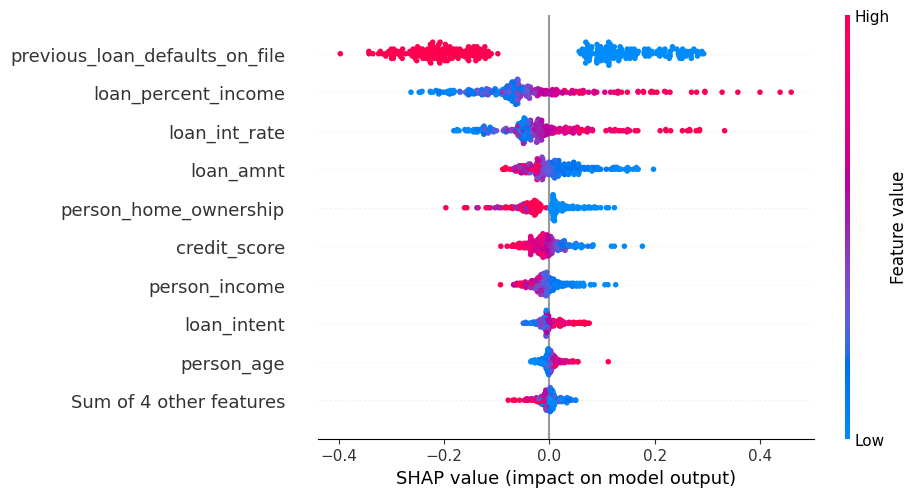

In [ ]:
shap.plots.beeswarm(shap_values)

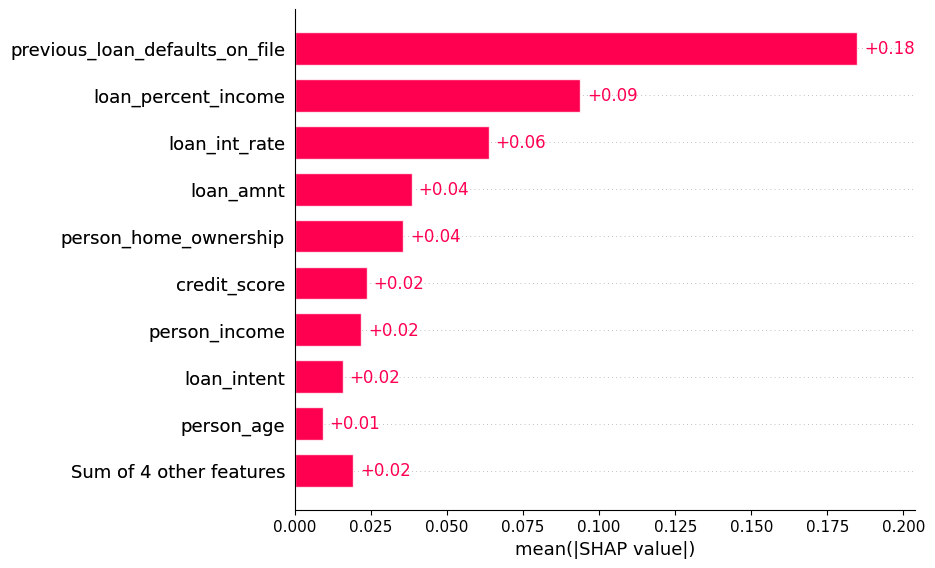

In [ ]:
shap.plots.bar(shap_values)

## PCA

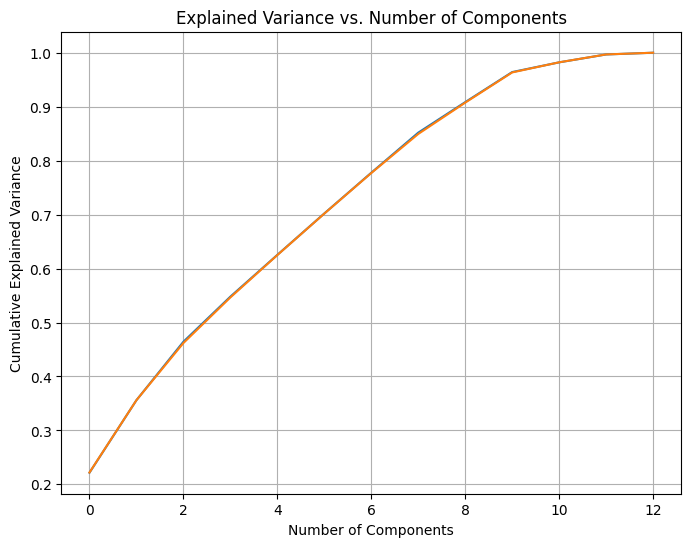

In [ ]:
from sklearn.decomposition import PCA

pca1 = PCA().fit(X_train_norm)
pca2 = PCA().fit(X_test_norm)

plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca1.explained_variance_ratio_))
plt.plot(np.cumsum(pca2.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [ ]:
pca = PCA(n_components=9)
X_train_trans = pca.fit_transform(X_train_norm)
X_test_trans = pca.fit_transform(X_test_norm)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(2, activation='sigmoid')])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)

history = model.fit(X_train_trans,
                    y_train,
                    batch_size=256,
                    epochs=300,
                    validation_data=(X_test_trans, y_test),
                    callbacks=[early_stopping])

Epoch 1/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7666 - loss: 0.6949 - val_accuracy: 0.8664 - val_loss: 0.4402
Epoch 2/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8726 - loss: 0.4093 - val_accuracy: 0.8794 - val_loss: 0.3388
Epoch 3/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8772 - loss: 0.3343 - val_accuracy: 0.8834 - val_loss: 0.3030
Epoch 4/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8834 - loss: 0.3007 - val_accuracy: 0.8846 - val_loss: 0.2904
Epoch 5/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8861 - loss: 0.2870 - val_accuracy: 0.8869 - val_loss: 0.2835
Epoch 6/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8834 - loss: 0.2875 - val_accuracy: 0.8867 - val_loss: 0.2800
Epoch 7/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8868 - loss: 0.2825 - val_accuracy: 0.8891 - val_loss: 0.2786
Epoch 8/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8888 - loss: 0.2770 - val_accu

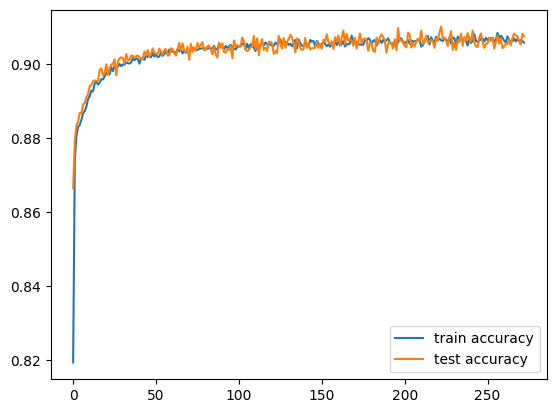

In [ ]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy')
plt.legend();

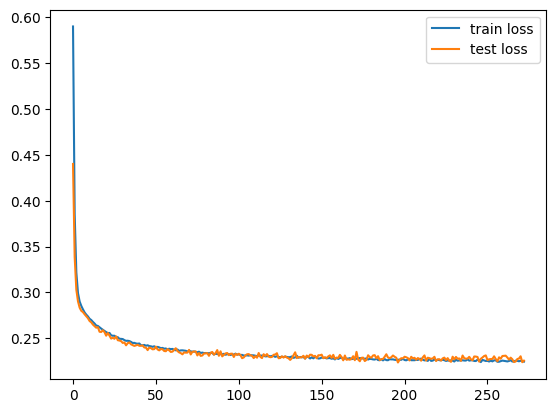

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend();

## VIF

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(vif_data)
    return vif_data

vif_info = calculate_vif(X)
high_vif = vif_info[vif_info['VIF'] > 10]
data = X.drop(columns=high_vif['feature'])

                           feature         VIF
0                       person_age  168.455629
1                    person_gender    2.228054
2                 person_education    3.601854
3                    person_income    2.882647
4                   person_emp_exp   12.189069
5            person_home_ownership    2.129222
6                        loan_amnt    7.196549
7                      loan_intent    2.931224
8                    loan_int_rate   14.963402
9              loan_percent_income    7.726354
10      cb_person_cred_hist_length   12.142920
11                    credit_score   92.537044
12  previous_loan_defaults_on_file    2.177147


In [ ]:
data['loan_status'] = y

In [ ]:
X = data.drop('loan_status', axis=1)
y = data['loan_status'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=3, stratify=y)
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.fit_transform(X_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(2, activation='sigmoid')])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)

history = model.fit(X_train_norm,
                    y_train,
                    batch_size=256,
                    epochs=300,
                    validation_data=(X_test_norm, y_test),
                    callbacks=[early_stopping])

Epoch 1/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7602 - loss: 0.6962 - val_accuracy: 0.8522 - val_loss: 0.4412
Epoch 2/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8567 - loss: 0.4091 - val_accuracy: 0.8539 - val_loss: 0.3438
Epoch 3/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8582 - loss: 0.3348 - val_accuracy: 0.8571 - val_loss: 0.3121
Epoch 4/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8621 - loss: 0.3072 - val_accuracy: 0.8583 - val_loss: 0.2997
Epoch 5/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8614 - loss: 0.2987 - val_accuracy: 0.8579 - val_loss: 0.2945
Epoch 6/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8598 - loss: 0.2955 - val_accuracy: 0.8586 - val_loss: 0.2913
Epoch 7/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8594 - loss: 0.2930 - val_accuracy: 0.8601 - val_loss: 0.2889
Epoch 8/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8638 - loss: 0.2869 - val_accu

## LDA

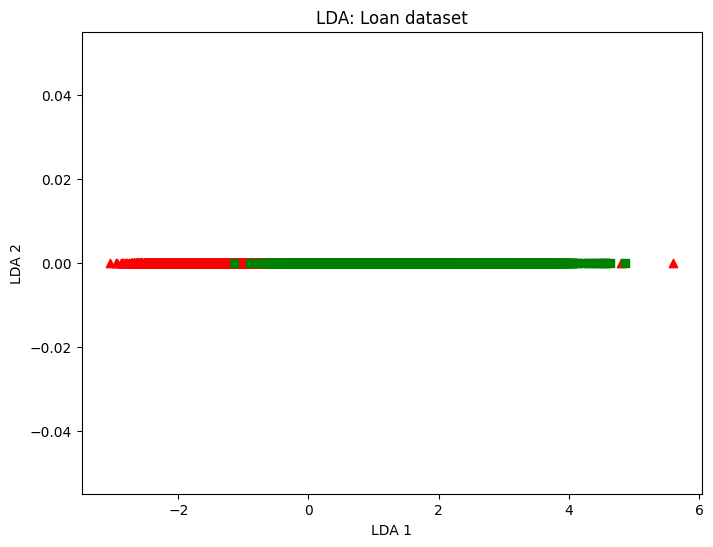

LDA-based Logistic Regression Accuracy: 0.89


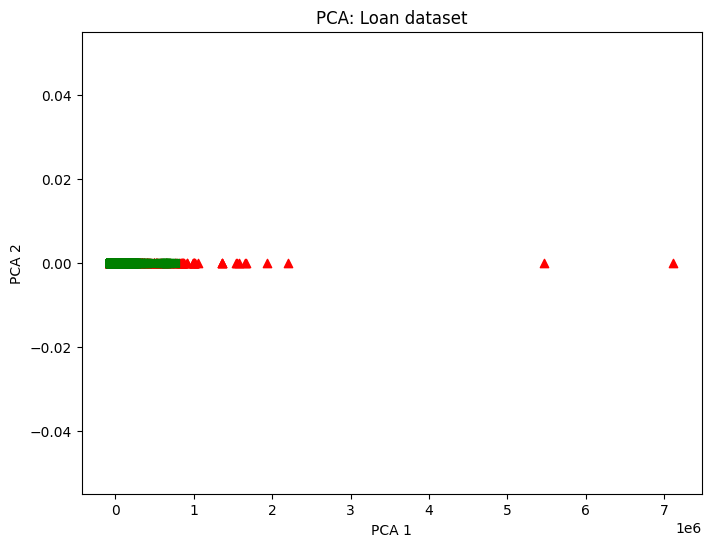

PCA-based Logistic Regression Accuracy: 0.82


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [99]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression

# 2. Применение LDA
lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

plt.figure(figsize=(8, 6))
for label, marker, color in zip(range(2), ('^', 's'), ('red', 'green')):
    plt.scatter(X_train_lda[y_train == label, 0],
                np.zeros_like(X_train_lda[y_train == label, 0]),
                marker=marker, color=color)
plt.xlabel('LDA 1')
plt.ylabel('LDA 2')
plt.title('LDA: Loan dataset')
plt.show()

# 3. Классификация с использованием LDA
lr = LogisticRegression()
lr.fit(X_train_lda, y_train)
y_pred = lr.predict(X_test_lda)
print(f"LDA-based Logistic Regression Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# 4. Сравнение с PCA
pca = PCA(n_components=9)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

plt.figure(figsize=(8, 6))
for label, marker, color in zip(range(2), ('^', 's'), ('red', 'green')):
    plt.scatter(X_train_pca[y_train == label, 0],
                np.zeros_like(X_train_lda[y_train == label, 0]),
                marker=marker, color=color)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA: Loan dataset')
plt.show()

lr_pca = LogisticRegression()
lr_pca.fit(X_train_pca, y_train)
y_pred_pca = lr_pca.predict(X_test_pca)
print(f"PCA-based Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_pca):.2f}")

In [94]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(2, activation='sigmoid')])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)

history = model.fit(X_train_lda,
                    y_train_cat,
                    batch_size=256,
                    epochs=300,
                    validation_data=(X_test_lda, y_test_cat),
                    callbacks=[early_stopping])

Epoch 1/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8050 - loss: 0.5963 - val_accuracy: 0.8796 - val_loss: 0.3604
Epoch 2/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8808 - loss: 0.3319 - val_accuracy: 0.8904 - val_loss: 0.2735
Epoch 3/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8918 - loss: 0.2698 - val_accuracy: 0.8908 - val_loss: 0.2606
Epoch 4/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8918 - loss: 0.2616 - val_accuracy: 0.8911 - val_loss: 0.2561
Epoch 5/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8881 - loss: 0.2620 - val_accuracy: 0.8909 - val_loss: 0.2533
Epoch 6/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8919 - loss: 0.2542 - val_accuracy: 0.8909 - val_loss: 0.2511
Epoch 7/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8867 - loss: 0.2559 - val_accuracy: 0.8908 - val_loss: 0.2497
Epoch 8/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8900 - loss: 0.2542 - val_accu

## t-SNE

<ipython-input-98-d35604a331ac>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, edgecolors='k', cmap=plt.cm.get_cmap('jet', 10))


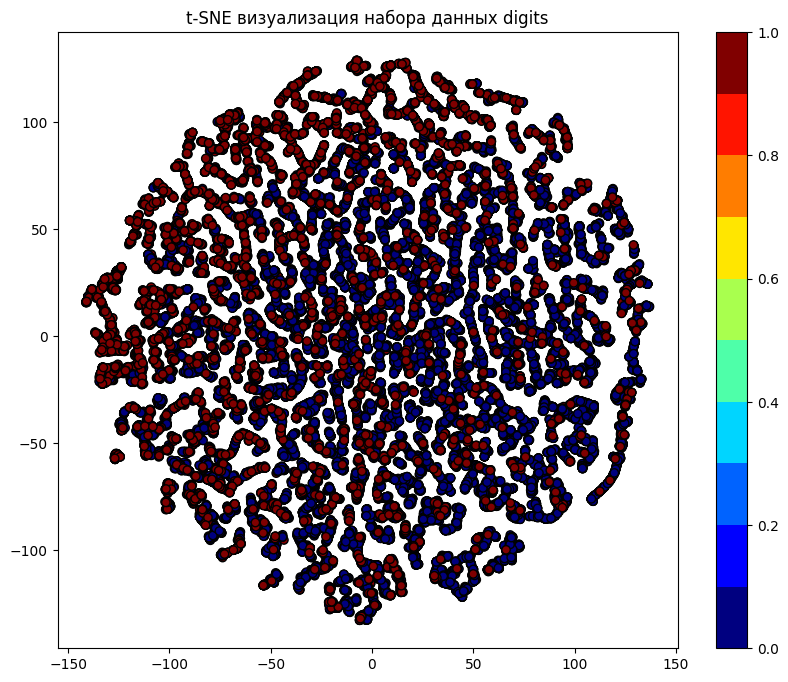

In [98]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, edgecolors='k', cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar()
plt.title('t-SNE визуализация набора данных digits')
plt.show()

## UMAP

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
<ipython-input-101-a63a5b236144>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolors='k', cmap=plt.cm.get_cmap('jet', 3))
<ipython-input-101-a63a5b236144>:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  axes[1].scatter(X_tsne

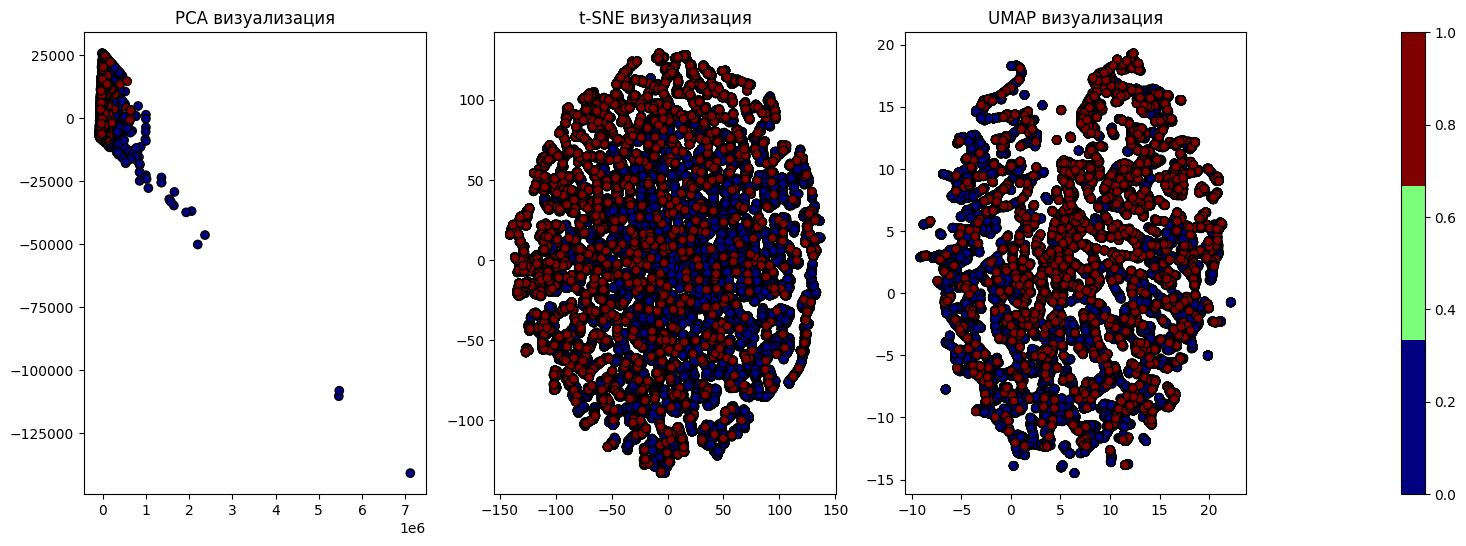

In [101]:
from umap import UMAP

# Применение PCA
X_pca = PCA(n_components=2).fit_transform(X)

# Применение t-SNE
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)

# Применение UMAP
X_umap = UMAP(n_components=2, random_state=42).fit_transform(X)

# Визуализация результатов
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolors='k', cmap=plt.cm.get_cmap('jet', 3))
axes[0].set_title('PCA визуализация')

axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, edgecolors='k', cmap=plt.cm.get_cmap('jet', 3))
axes[1].set_title('t-SNE визуализация')

axes[2].scatter(X_umap[:, 0], X_umap[:, 1], c=y, edgecolors='k', cmap=plt.cm.get_cmap('jet', 3))
axes[2].set_title('UMAP визуализация')

plt.colorbar(mappable=axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, edgecolors='k', cmap=plt.cm.get_cmap('jet', 3)), ax=axes, orientation='vertical', pad=0.1)
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


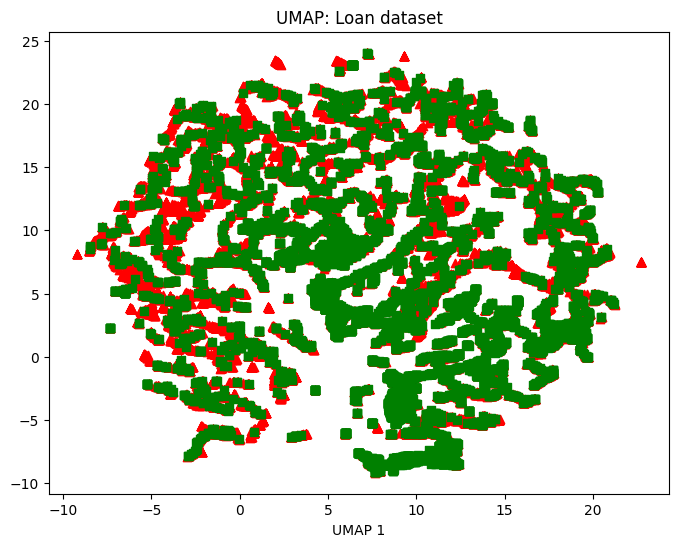

UMAP-based Logistic Regression Accuracy: 0.78


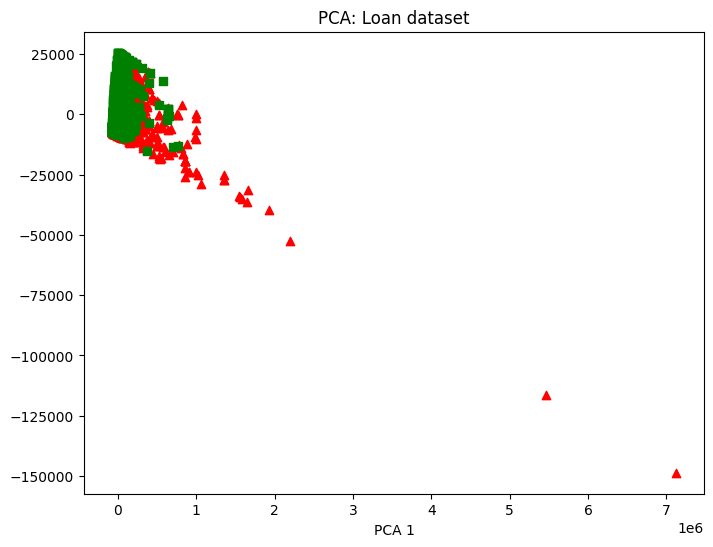

PCA-based Logistic Regression Accuracy: 0.79


In [107]:
# 2. Применение UMAP
umap_model = UMAP(n_components=2)
X_train_umap = umap_model.fit_transform(X_train)
X_test_umap = umap_model.transform(X_test)

plt.figure(figsize=(8, 6))
for label, marker, color in zip(range(2), ('^', 's'), ('red', 'green')):
    plt.scatter(X_train_umap[y_train == label, 0],
                X_train_umap[y_train == label, 1],
                marker=marker, color=color)
plt.xlabel('UMAP 1')
plt.title('UMAP: Loan dataset')
plt.show()

# 3. Классификация с использованием UMAP
lr = LogisticRegression()
lr.fit(X_train_umap, y_train)
y_pred = lr.predict(X_test_umap)
print(f"UMAP-based Logistic Regression Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# 4. Сравнение с PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

plt.figure(figsize=(8, 6))
for label, marker, color in zip(range(2), ('^', 's'), ('red', 'green')):
    plt.scatter(X_train_pca[y_train == label, 0],
                X_train_pca[y_train == label, 1],
                marker=marker, color=color)
plt.xlabel('PCA 1')
plt.title('PCA: Loan dataset')
plt.show()

lr_pca = LogisticRegression()
lr_pca.fit(X_train_pca, y_train)
y_pred_pca = lr_pca.predict(X_test_pca)
print(f"PCA-based Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_pca):.2f}")

In [ ]:
X = df.drop('loan_status', axis=1)
y = df['loan_status'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=3, stratify=y)
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.fit_transform(X_test)

In [ ]:
vif_info = calculate_vif(X)
high_vif = vif_info[vif_info['VIF'] > 10]
data = X.drop(columns=high_vif['feature'])

                           feature         VIF
0                       person_age  168.455629
1                    person_gender    2.228054
2                 person_education    3.601854
3                    person_income    2.882647
4                   person_emp_exp   12.189069
5            person_home_ownership    2.129222
6                        loan_amnt    7.196549
7                      loan_intent    2.931224
8                    loan_int_rate   14.963402
9              loan_percent_income    7.726354
10      cb_person_cred_hist_length   12.142920
11                    credit_score   92.537044
12  previous_loan_defaults_on_file    2.177147


In [ ]:
data['loan_status'] = y

In [ ]:
X = data.drop('loan_status', axis=1)
y = data['loan_status'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=3, stratify=y)

scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.fit_transform(X_test)

X_train_normpd = pd.DataFrame(X_train_norm, columns=X.columns)
X_test_normpd = pd.DataFrame(X_test_norm, columns=X.columns)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='relu')])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='mse',
              metrics=['mse'])

early_stopping = EarlyStopping(monitor='val_mse', patience=50, restore_best_weights=True)

history = model.fit(X_train_normpd,
                    y_train,
                    batch_size=64,
                    epochs=60,
                    validation_data=(X_test_normpd, y_test),
                    callbacks=[early_stopping])

Epoch 1/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1267 - mse: 0.1267 - val_loss: 0.0906 - val_mse: 0.0906
Epoch 2/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0988 - mse: 0.0988 - val_loss: 0.0892 - val_mse: 0.0892
Epoch 3/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0966 - mse: 0.0966 - val_loss: 0.0879 - val_mse: 0.0879
Epoch 4/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0940 - mse: 0.0940 - val_loss: 0.0879 - val_mse: 0.0879
Epoch 5/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0937 - mse: 0.0937 - val_loss: 0.0870 - val_mse: 0.0870
Epoch 6/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0916 - mse: 0.0916 - val_loss: 0.0866 - val_mse: 0.0866
Epoch 7/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0919 - mse: 0.0919 - val_loss: 0.0864 - val_mse: 0.0864
Epoch 8/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0916 - mse: 0.0916 - val_loss: 0.0864 - val_mse: 0.0864
Epoch 9/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

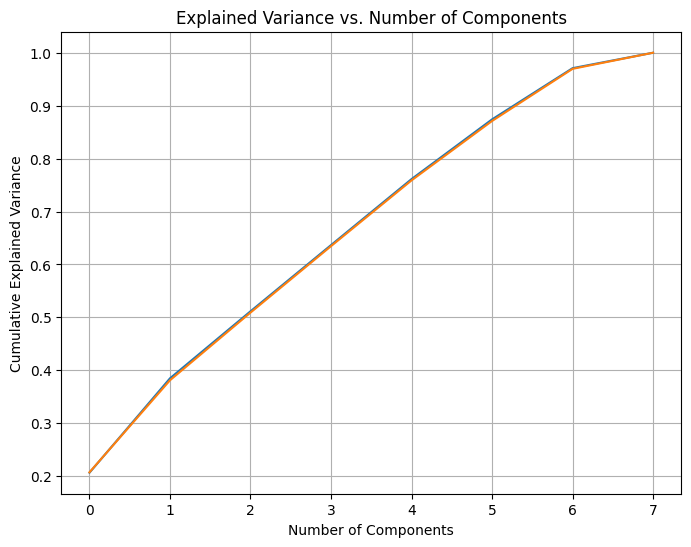

In [ ]:
pca1 = PCA().fit(X_train_normpd)
pca2 = PCA().fit(X_test_normpd)

plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca1.explained_variance_ratio_))
plt.plot(np.cumsum(pca2.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [ ]:
pca = PCA(n_components=6)
X_train_trans = pca.fit_transform(X_train_normpd)
X_test_trans = pca.fit_transform(X_test_normpd)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='relu')])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='mse',
              metrics=['mse'])

early_stopping = EarlyStopping(monitor='val_mse', patience=50, restore_best_weights=True)

history = model.fit(X_train_trans,
                    y_train,
                    batch_size=64,
                    epochs=60,
                    validation_data=(X_test_trans, y_test),
                    callbacks=[early_stopping])

Epoch 1/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 0.1222 - mse: 0.1222 - val_loss: 0.0961 - val_mse: 0.0961
Epoch 2/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1007 - mse: 0.1007 - val_loss: 0.0943 - val_mse: 0.0943
Epoch 3/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0977 - mse: 0.0977 - val_loss: 0.0934 - val_mse: 0.0934
Epoch 4/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0957 - mse: 0.0957 - val_loss: 0.0924 - val_mse: 0.0924
Epoch 5/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0950 - mse: 0.0950 - val_loss: 0.0917 - val_mse: 0.0917
Epoch 6/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0934 - mse: 0.0934 - val_loss: 0.0914 - val_mse: 0.0914
Epoch 7/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0918 - mse: 0.0918 - val_loss: 0.0910 - val_mse: 0.0910
Epoch 8/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0932 - mse: 0.0932 - val_loss: 0.0908 - val_mse: 0.0908
Epoch 9/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - l

In [ ]:
explainer = shap.Explainer(model.predict, X_train_trans[:100])
shap_values = explainer(X_test_trans[:100])

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   4%|▍         | 4/100 [00:00<?, ?it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   6%|▌         | 6/100 [00:11<00:43,  2.15it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   7%|▋         | 7/100 [00:12<00:58,  1.58it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   8%|▊         | 8/100 [00:13<01:03,  1.45it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:   9%|▉         | 9/100 [00:13<00:59,  1.54it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  10%|█         | 10/100 [00:14<00:53,  1.67it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  11%|█         | 11/100 [00:14<00:50,  1.75it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  12%|█▏        | 12/100 [00:15<00:47,  1.84it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  13%|█▎        | 13/100 [00:16<00:48,  1.80it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  14%|█▍        | 14/100 [00:16<00:54,  1.59it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  15%|█▌        | 15/100 [00:17<00:57,  1.47it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  16%|█▌        | 16/100 [00:18<01:00,  1.38it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  17%|█▋        | 17/100 [00:19<01:02,  1.33it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  18%|█▊        | 18/100 [00:19<00:55,  1.49it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  19%|█▉        | 19/100 [00:20<00:50,  1.62it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  20%|██        | 20/100 [00:20<00:46,  1.72it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  21%|██        | 21/100 [00:21<00:51,  1.54it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  22%|██▏       | 22/100 [00:22<00:49,  1.58it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  23%|██▎       | 23/100 [00:22<00:48,  1.60it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  24%|██▍       | 24/100 [00:23<00:54,  1.38it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  25%|██▌       | 25/100 [00:24<00:57,  1.30it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  26%|██▌       | 26/100 [00:25<01:00,  1.22it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  27%|██▋       | 27/100 [00:26<01:00,  1.21it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  28%|██▊       | 28/100 [00:26<00:52,  1.37it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  29%|██▉       | 29/100 [00:27<00:49,  1.44it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  30%|███       | 30/100 [00:28<00:50,  1.38it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  31%|███       | 31/100 [00:28<00:45,  1.51it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  32%|███▏      | 32/100 [00:29<00:41,  1.64it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  33%|███▎      | 33/100 [00:30<00:44,  1.50it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  34%|███▍      | 34/100 [00:30<00:46,  1.41it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  35%|███▌      | 35/100 [00:31<00:42,  1.54it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  36%|███▌      | 36/100 [00:31<00:38,  1.64it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  37%|███▋      | 37/100 [00:32<00:36,  1.74it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  38%|███▊      | 38/100 [00:32<00:34,  1.80it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  39%|███▉      | 39/100 [00:33<00:32,  1.86it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  40%|████      | 40/100 [00:33<00:32,  1.87it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  41%|████      | 41/100 [00:34<00:30,  1.91it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  42%|████▏     | 42/100 [00:34<00:30,  1.92it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  43%|████▎     | 43/100 [00:35<00:29,  1.95it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  44%|████▍     | 44/100 [00:35<00:28,  1.94it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  45%|████▌     | 45/100 [00:36<00:34,  1.58it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  46%|████▌     | 46/100 [00:37<00:39,  1.36it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  47%|████▋     | 47/100 [00:38<00:42,  1.24it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  48%|████▊     | 48/100 [00:39<00:42,  1.22it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  49%|████▉     | 49/100 [00:40<00:37,  1.37it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  50%|█████     | 50/100 [00:40<00:33,  1.51it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  51%|█████     | 51/100 [00:41<00:34,  1.41it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  52%|█████▏    | 52/100 [00:42<00:35,  1.35it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  53%|█████▎    | 53/100 [00:42<00:31,  1.49it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  54%|█████▍    | 54/100 [00:43<00:28,  1.61it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  55%|█████▌    | 55/100 [00:43<00:26,  1.70it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  56%|█████▌    | 56/100 [00:44<00:24,  1.78it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  57%|█████▋    | 57/100 [00:44<00:23,  1.84it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  58%|█████▊    | 58/100 [00:45<00:26,  1.60it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  59%|█████▉    | 59/100 [00:46<00:24,  1.69it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  60%|██████    | 60/100 [00:47<00:26,  1.53it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  61%|██████    | 61/100 [00:47<00:23,  1.64it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  62%|██████▏   | 62/100 [00:47<00:21,  1.74it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  63%|██████▎   | 63/100 [00:48<00:20,  1.81it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  64%|██████▍   | 64/100 [00:49<00:19,  1.85it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  65%|██████▌   | 65/100 [00:49<00:19,  1.79it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  66%|██████▌   | 66/100 [00:50<00:22,  1.53it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  67%|██████▋   | 67/100 [00:51<00:23,  1.38it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  68%|██████▊   | 68/100 [00:52<00:24,  1.28it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  69%|██████▉   | 69/100 [00:53<00:24,  1.25it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  70%|███████   | 70/100 [00:53<00:21,  1.38it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  71%|███████   | 71/100 [00:54<00:19,  1.52it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  72%|███████▏  | 72/100 [00:54<00:19,  1.43it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  73%|███████▎  | 73/100 [00:55<00:19,  1.37it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  74%|███████▍  | 74/100 [00:56<00:19,  1.33it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  75%|███████▌  | 75/100 [00:57<00:17,  1.40it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  76%|███████▌  | 76/100 [00:58<00:19,  1.25it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  77%|███████▋  | 77/100 [00:59<00:19,  1.18it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  78%|███████▊  | 78/100 [01:00<00:18,  1.19it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  79%|███████▉  | 79/100 [01:00<00:17,  1.18it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  80%|████████  | 80/100 [01:01<00:15,  1.33it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  81%|████████  | 81/100 [01:02<00:13,  1.41it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  82%|████████▏ | 82/100 [01:02<00:11,  1.50it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  83%|████████▎ | 83/100 [01:03<00:11,  1.52it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  84%|████████▍ | 84/100 [01:04<00:11,  1.35it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  85%|████████▌ | 85/100 [01:05<00:11,  1.25it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  86%|████████▌ | 86/100 [01:05<00:11,  1.26it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  87%|████████▋ | 87/100 [01:06<00:10,  1.19it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  88%|████████▊ | 88/100 [01:07<00:08,  1.34it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  89%|████████▉ | 89/100 [01:07<00:07,  1.48it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  90%|█████████ | 90/100 [01:08<00:06,  1.59it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  91%|█████████ | 91/100 [01:08<00:05,  1.68it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  92%|█████████▏| 92/100 [01:09<00:04,  1.76it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  93%|█████████▎| 93/100 [01:10<00:04,  1.57it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  94%|█████████▍| 94/100 [01:10<00:03,  1.59it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  95%|█████████▌| 95/100 [01:11<00:02,  1.69it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  96%|█████████▌| 96/100 [01:12<00:02,  1.52it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  97%|█████████▋| 97/100 [01:12<00:02,  1.43it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  98%|█████████▊| 98/100 [01:13<00:01,  1.56it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  99%|█████████▉| 99/100 [01:13<00:00,  1.67it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer: 100%|██████████| 100/100 [01:14<00:00,  1.72it/s]

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer: 101it [01:14,  1.29it/s]


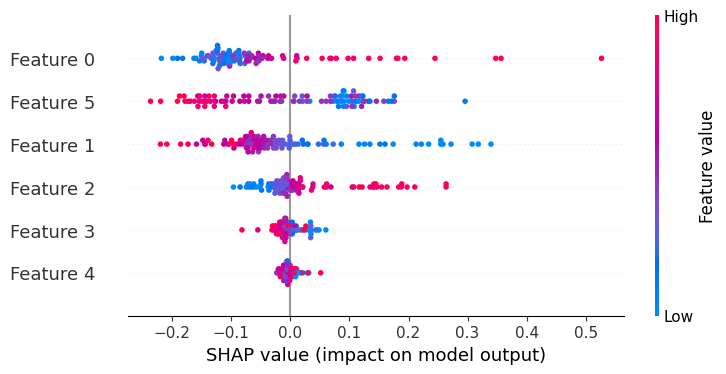

In [ ]:
shap.plots.beeswarm(shap_values)

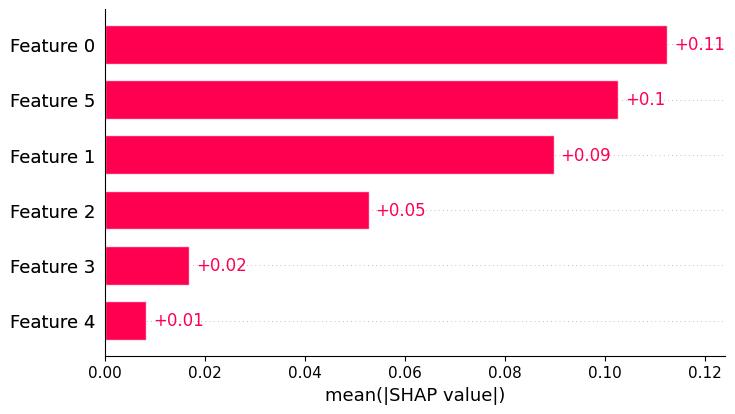

In [ ]:
shap.plots.bar(shap_values)

In [ ]:
X_train_finish = X_train_trans[:, [0, 5, 1, 2]]
X_test_finish = X_test_trans[:, [0, 5, 1, 2]]

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='relu')])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='mse',
              metrics=['mse'])

early_stopping = EarlyStopping(monitor='val_mse', patience=50, restore_best_weights=True)

history = model.fit(X_train_finish,
                    y_train,
                    batch_size=64,
                    epochs=60,
                    validation_data=(X_test_finish, y_test),
                    callbacks=[early_stopping])

Epoch 1/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1317 - mse: 0.1317 - val_loss: 0.0939 - val_mse: 0.0939
Epoch 2/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1000 - mse: 0.1000 - val_loss: 0.0921 - val_mse: 0.0921
Epoch 3/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0997 - mse: 0.0997 - val_loss: 0.0913 - val_mse: 0.0913
Epoch 4/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0948 - mse: 0.0948 - val_loss: 0.0902 - val_mse: 0.0902
Epoch 5/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0946 - mse: 0.0946 - val_loss: 0.0896 - val_mse: 0.0896
Epoch 6/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0937 - mse: 0.0937 - val_loss: 0.0892 - val_mse: 0.0892
Epoch 7/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0920 - mse: 0.0920 - val_loss: 0.0891 - val_mse: 0.0891
Epoch 8/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0933 - mse: 0.0933 - val_loss: 0.0890 - val_mse: 0.0890
Epoch 9/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

In [ ]:
explainer = shap.Explainer(model.predict, X_train_finish[:100])
shap_values = explainer(X_test_finish[:100])

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
50/50 ━━━━━━━

ExactExplainer explainer:  17%|█▋        | 17/100 [00:00<?, ?it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


ExactExplainer explainer:  19%|█▉        | 19/100 [00:11<00:30,  2.67it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  20%|██        | 20/100 [00:11<00:42,  1.90it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


ExactExplainer explainer:  21%|██        | 21/100 [00:12<00:52,  1.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  22%|██▏       | 22/100 [00:13<00:54,  1.44it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  23%|██▎       | 23/100 [00:14<00:51,  1.50it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  24%|██▍       | 24/100 [00:14<00:45,  1.68it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  25%|██▌       | 25/100 [00:15<00:45,  1.66it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


ExactExplainer explainer:  26%|██▌       | 26/100 [00:15<00:43,  1.69it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  27%|██▋       | 27/100 [00:16<00:41,  1.74it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  28%|██▊       | 28/100 [00:16<00:39,  1.83it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  29%|██▉       | 29/100 [00:17<00:41,  1.72it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  30%|███       | 30/100 [00:18<00:43,  1.61it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


ExactExplainer explainer:  31%|███       | 31/100 [00:19<00:56,  1.22it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  32%|███▏      | 32/100 [00:20<00:50,  1.35it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  33%|███▎      | 33/100 [00:20<00:47,  1.42it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  34%|███▍      | 34/100 [00:21<00:44,  1.49it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  35%|███▌      | 35/100 [00:21<00:36,  1.79it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  36%|███▌      | 36/100 [00:21<00:31,  2.05it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  37%|███▋      | 37/100 [00:22<00:27,  2.30it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  38%|███▊      | 38/100 [00:22<00:23,  2.60it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  39%|███▉      | 39/100 [00:22<00:22,  2.77it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  40%|████      | 40/100 [00:23<00:20,  2.87it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


ExactExplainer explainer:  41%|████      | 41/100 [00:24<00:33,  1.75it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


ExactExplainer explainer:  42%|████▏     | 42/100 [00:25<00:43,  1.33it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


ExactExplainer explainer:  43%|████▎     | 43/100 [00:26<00:45,  1.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


ExactExplainer explainer:  44%|████▍     | 44/100 [00:27<00:45,  1.24it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  45%|████▌     | 45/100 [00:27<00:42,  1.29it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  46%|████▌     | 46/100 [00:28<00:34,  1.55it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  47%|████▋     | 47/100 [00:28<00:29,  1.83it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  48%|████▊     | 48/100 [00:28<00:23,  2.18it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  49%|████▉     | 49/100 [00:28<00:20,  2.52it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  50%|█████     | 50/100 [00:29<00:18,  2.66it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  51%|█████     | 51/100 [00:29<00:17,  2.82it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  52%|█████▏    | 52/100 [00:29<00:15,  3.05it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  53%|█████▎    | 53/100 [00:30<00:15,  3.06it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  54%|█████▍    | 54/100 [00:30<00:15,  3.06it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  55%|█████▌    | 55/100 [00:30<00:14,  3.10it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  56%|█████▌    | 56/100 [00:31<00:13,  3.26it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  57%|█████▋    | 57/100 [00:31<00:13,  3.19it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  58%|█████▊    | 58/100 [00:31<00:12,  3.33it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  59%|█████▉    | 59/100 [00:31<00:11,  3.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  60%|██████    | 60/100 [00:32<00:11,  3.40it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  61%|██████    | 61/100 [00:32<00:11,  3.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  62%|██████▏   | 62/100 [00:32<00:11,  3.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  63%|██████▎   | 63/100 [00:33<00:10,  3.44it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  64%|██████▍   | 64/100 [00:33<00:10,  3.33it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  65%|██████▌   | 65/100 [00:33<00:10,  3.42it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  66%|██████▌   | 66/100 [00:33<00:10,  3.34it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  67%|██████▋   | 67/100 [00:34<00:09,  3.45it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  68%|██████▊   | 68/100 [00:34<00:09,  3.34it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  69%|██████▉   | 69/100 [00:34<00:09,  3.44it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  70%|███████   | 70/100 [00:35<00:09,  3.32it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  71%|███████   | 71/100 [00:35<00:08,  3.27it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  72%|███████▏  | 72/100 [00:35<00:08,  3.40it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  73%|███████▎  | 73/100 [00:36<00:07,  3.54it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  74%|███████▍  | 74/100 [00:36<00:07,  3.41it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  75%|███████▌  | 75/100 [00:36<00:07,  3.46it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  76%|███████▌  | 76/100 [00:36<00:07,  3.39it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  77%|███████▋  | 77/100 [00:37<00:06,  3.35it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  78%|███████▊  | 78/100 [00:37<00:06,  3.39it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  79%|███████▉  | 79/100 [00:37<00:07,  2.94it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  80%|████████  | 80/100 [00:38<00:07,  2.69it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  81%|████████  | 81/100 [00:38<00:07,  2.53it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  82%|████████▏ | 82/100 [00:39<00:06,  2.58it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  83%|████████▎ | 83/100 [00:39<00:06,  2.62it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  84%|████████▍ | 84/100 [00:40<00:06,  2.51it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  85%|████████▌ | 85/100 [00:40<00:06,  2.15it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  86%|████████▌ | 86/100 [00:41<00:06,  2.12it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  87%|████████▋ | 87/100 [00:41<00:05,  2.43it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  88%|████████▊ | 88/100 [00:41<00:04,  2.61it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  89%|████████▉ | 89/100 [00:42<00:04,  2.75it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  90%|█████████ | 90/100 [00:42<00:03,  2.83it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  91%|█████████ | 91/100 [00:42<00:03,  2.93it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  92%|█████████▏| 92/100 [00:42<00:02,  3.03it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  93%|█████████▎| 93/100 [00:43<00:02,  3.09it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  94%|█████████▍| 94/100 [00:43<00:01,  3.11it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  95%|█████████▌| 95/100 [00:43<00:01,  3.25it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  96%|█████████▌| 96/100 [00:44<00:01,  3.39it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  97%|█████████▋| 97/100 [00:44<00:00,  3.37it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  98%|█████████▊| 98/100 [00:44<00:00,  3.44it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  99%|█████████▉| 99/100 [00:45<00:00,  3.38it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer: 100%|██████████| 100/100 [00:45<00:00,  3.43it/s]

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer: 101it [00:45,  1.84it/s]


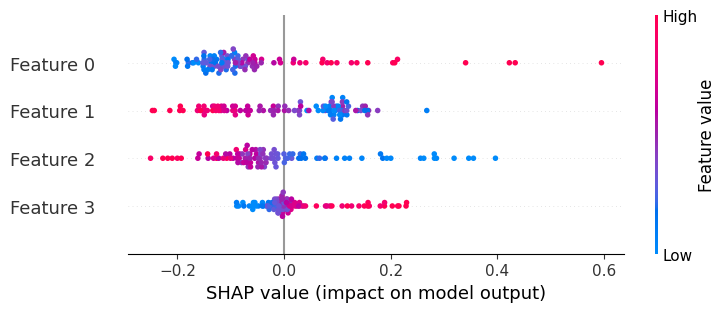

In [ ]:
shap.plots.beeswarm(shap_values)

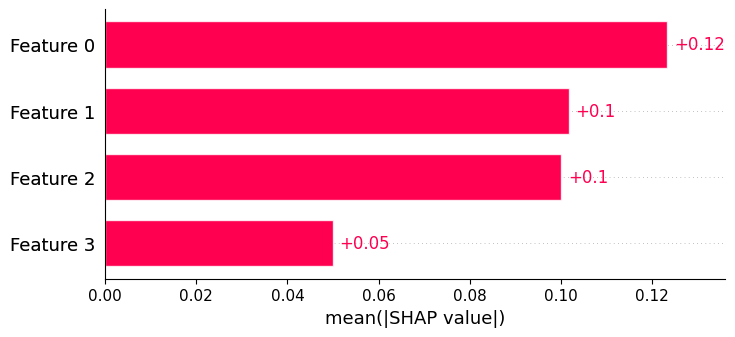

In [ ]:
shap.plots.bar(shap_values)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(2, activation='sigmoid')])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)

history = model.fit(X_train_finish,
                    y_train_cat,
                    batch_size=256,
                    epochs=300,
                    validation_data=(X_test_finish, y_test_cat),
                    callbacks=[early_stopping])

Epoch 1/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6651 - loss: 0.6862 - val_accuracy: 0.8412 - val_loss: 0.4277
Epoch 2/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8519 - loss: 0.3998 - val_accuracy: 0.8479 - val_loss: 0.3485
Epoch 3/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8509 - loss: 0.3404 - val_accuracy: 0.8481 - val_loss: 0.3236
Epoch 4/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8572 - loss: 0.3169 - val_accuracy: 0.8498 - val_loss: 0.3129
Epoch 5/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8601 - loss: 0.3046 - val_accuracy: 0.8504 - val_loss: 0.3083
Epoch 6/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8596 - loss: 0.3032 - val_accuracy: 0.8558 - val_loss: 0.3050
Epoch 7/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8590 - loss: 0.3018 - val_accuracy: 0.8570 - val_loss: 0.3014
Epoch 8/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8586 - loss: 0.3002 - val_acc

## Combine

In [205]:
X = df.drop('loan_status', axis=1)
y = df['loan_status'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=3, stratify=y)

In [206]:
model = RandomForestClassifier()
model.fit(X_train_lda, y_train)
y_pred = model.predict(X_test_lda)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Random Forest Accuracy: 0.93


### VIF

In [207]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["feature"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    print(vif_data)
    return vif_data

vif_info = calculate_vif(X)

                           feature         VIF
0                       person_age  168.455629
1                    person_gender    2.228054
2                 person_education    3.601854
3                    person_income    2.882647
4                   person_emp_exp   12.189069
5            person_home_ownership    2.129222
6                        loan_amnt    7.196549
7                      loan_intent    2.931224
8                    loan_int_rate   14.963402
9              loan_percent_income    7.726354
10      cb_person_cred_hist_length   12.142920
11                    credit_score   92.537044
12  previous_loan_defaults_on_file    2.177147


In [208]:
high_vif = vif_info[vif_info['VIF'] > 10]
data = X.drop(columns=high_vif['feature'])

In [209]:
vif_info = calculate_vif(data)

                          feature       VIF
0                   person_gender  2.040371
1                person_education  2.959635
2                   person_income  2.494606
3           person_home_ownership  2.000044
4                       loan_amnt  7.042207
5                     loan_intent  2.511980
6             loan_percent_income  6.088207
7  previous_loan_defaults_on_file  1.878542


In [236]:
X_train, X_test, y_train, y_test = train_test_split(data, y, train_size = 0.8, random_state=3, stratify=y)

scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.fit_transform(X_test)

In [212]:
model = RandomForestClassifier()
model.fit(X_train_lda, y_train)
y_pred = model.predict(X_test_lda)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Random Forest Accuracy: 0.89


### shap

In [213]:
explainer = shap.Explainer(lr.predict, X_train[:200])
shap_values = explainer(X_test[:200])

ExactExplainer explainer: 201it [00:41,  3.94it/s]


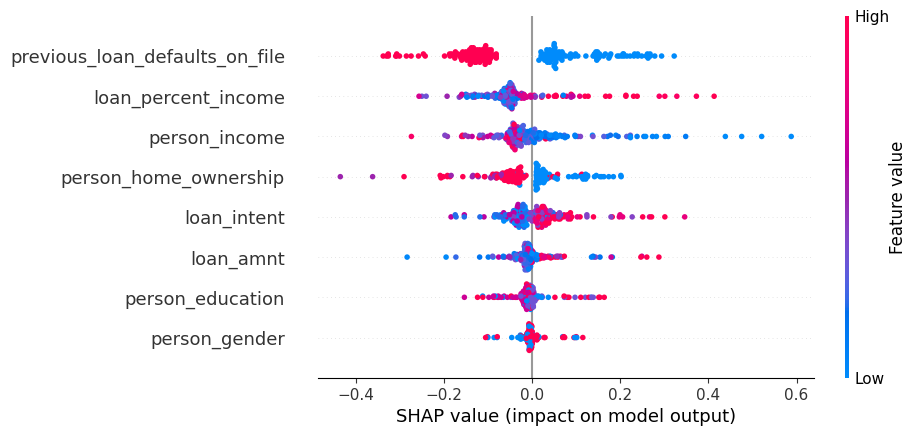

In [214]:
shap.plots.beeswarm(shap_values)

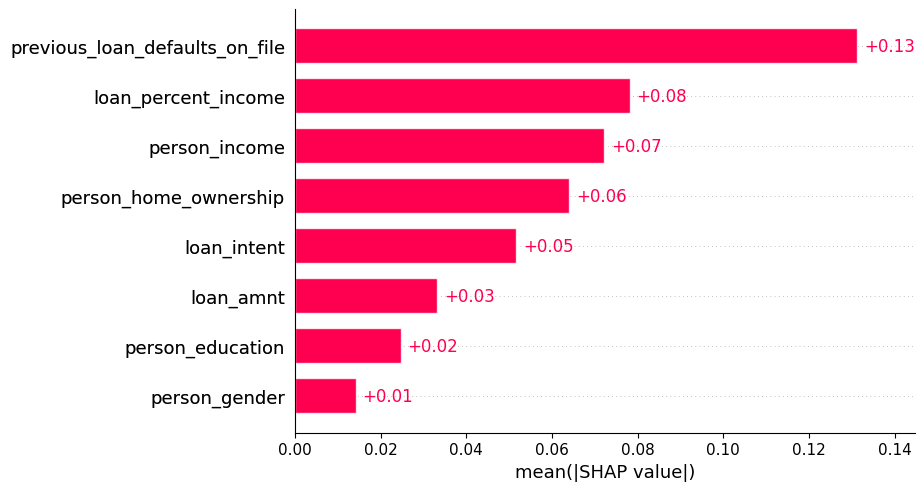

In [215]:
shap.plots.bar(shap_values)

In [237]:
X_train = X_train.iloc[:, [2, 3, 5, 6, 7]]
X_test = X_test.iloc[:, [2, 3, 5, 6, 7]]

scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.fit_transform(X_test)

In [219]:
model = RandomForestClassifier()
model.fit(X_train_lda, y_train)
y_pred = model.predict(X_test_lda)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Random Forest Accuracy: 0.90


### LDA

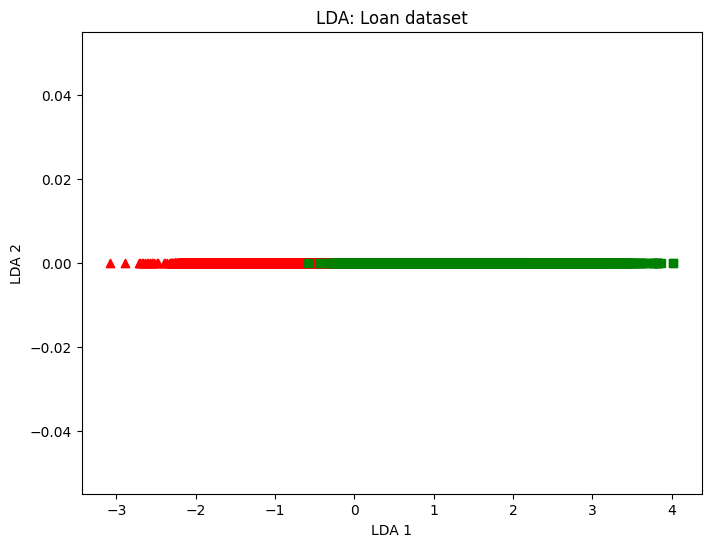

In [243]:
lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

plt.figure(figsize=(8, 6))
for label, marker, color in zip(range(2), ('^', 's'), ('red', 'green')):
    plt.scatter(X_train_lda[y_train == label, 0],
                np.zeros_like(X_train_lda[y_train == label, 0]),
                marker=marker, color=color)
plt.xlabel('LDA 1')
plt.ylabel('LDA 2')
plt.title('LDA: Loan dataset')
plt.show()

In [260]:
model = RandomForestClassifier()
model.fit(X_train_lda, y_train)
y_pred = model.predict(X_test_lda)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Random Forest Accuracy: 0.8490


### PCA

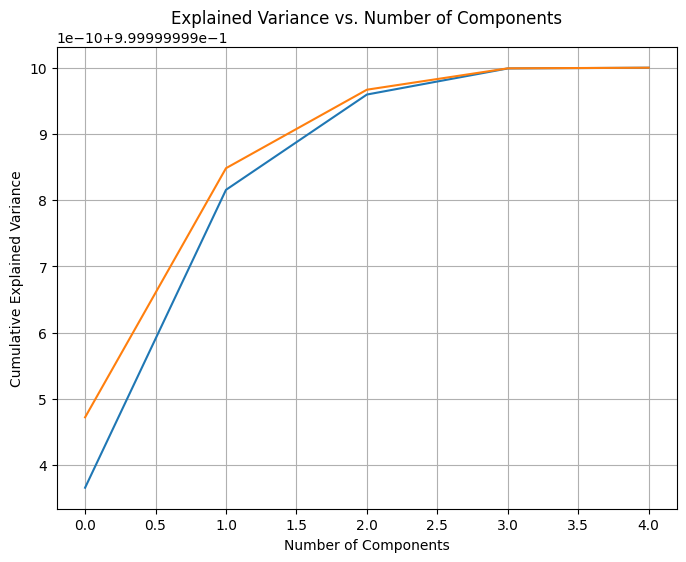

In [245]:
from sklearn.decomposition import PCA

pca1 = PCA().fit(X_train)
pca2 = PCA().fit(X_test)

plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca1.explained_variance_ratio_))
plt.plot(np.cumsum(pca2.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

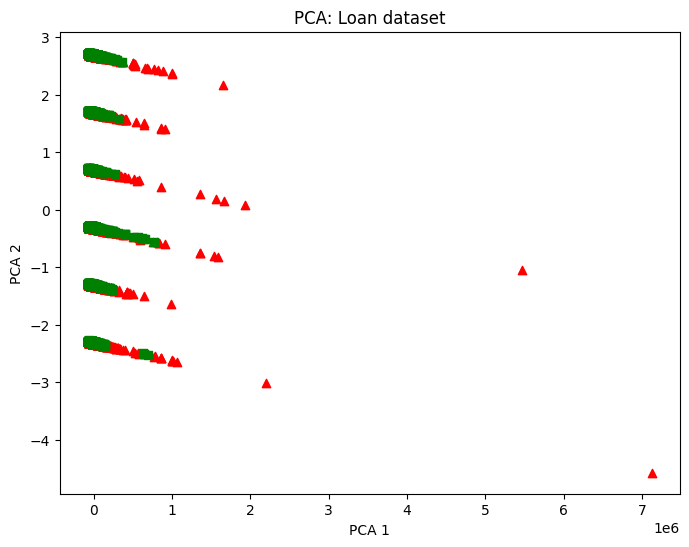

In [253]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

plt.figure(figsize=(8, 6))
for label, marker, color in zip(range(2), ('^', 's'), ('red', 'green')):
    plt.scatter(X_train_pca[y_train == label, 0],
                X_train_pca[y_train == label, 1],
                marker=marker, color=color)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA: Loan dataset')
plt.show()

In [259]:
model = RandomForestClassifier()
model.fit(X_train_pca, y_train)
y_pred = model.predict(X_test_pca)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Random Forest Accuracy: 0.8520


### UMAP

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


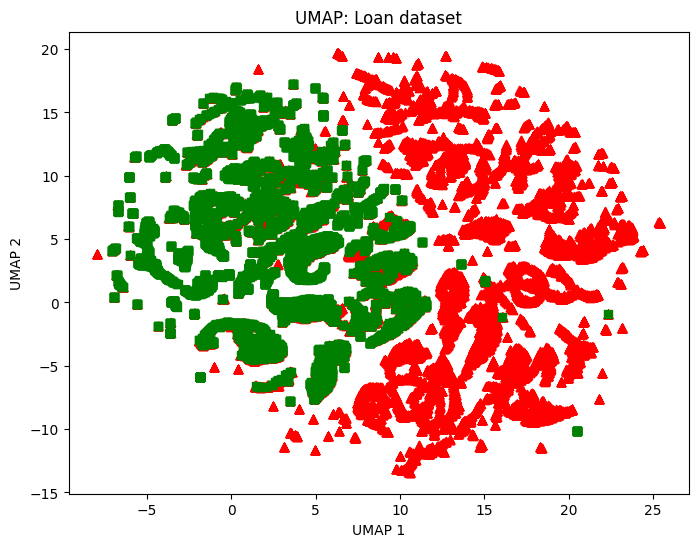

In [252]:
umap = UMAP(n_components=2)
X_train_umap = umap.fit_transform(X_train_norm)
X_test_umap = umap.transform(X_test_norm)

plt.figure(figsize=(8, 6))
for label, marker, color in zip(range(2), ('^', 's'), ('red', 'green')):
    plt.scatter(X_train_umap[y_train == label, 0],
                X_train_umap[y_train == label, 1],
                marker=marker, color=color)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP: Loan dataset')
plt.show()

In [258]:
model = RandomForestClassifier()
model.fit(X_train_umap, y_train)
y_pred = model.predict(X_test_umap)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Random Forest Accuracy: 0.8619


## vs Predict on 4 linear correlative parametrs (spoiler: combine lose:))

In [ ]:
top_correlations_to_parametr(df, 13, 13)

1. previous_loan_defaults_on_file AND loan_status: -0.54
2. loan_percent_income AND loan_status: 0.38
3. loan_int_rate AND loan_status: 0.33
4. person_home_ownership AND loan_status: -0.24
5. person_income AND loan_status: -0.14
6. loan_amnt AND loan_status: 0.11
7. loan_intent AND loan_status: 0.07
8. person_age AND loan_status: -0.02
9. person_emp_exp AND loan_status: -0.02
10. cb_person_cred_hist_length AND loan_status: -0.01
11. credit_score AND loan_status: -0.01
12. person_education AND loan_status: 0.00
13. person_gender AND loan_status: -0.00


In [255]:
X_corr = df.iloc[:, [12, 9, 8, 5]]
y = df['loan_status'].values

X_train_corr, X_test_corr, y_train, y_test = train_test_split(X_corr, y, train_size = 0.8, random_state=3, stratify=y)

scaler = StandardScaler()
X_train_corr_norm = scaler.fit_transform(X_train_corr)
X_test_corr_norm = scaler.fit_transform(X_test_corr)

X_train_corr_normpd = pd.DataFrame(X_train_corr_norm, columns=X_corr.columns)
X_test_corr_normpd = pd.DataFrame(X_test_corr_norm, columns=X_corr.columns)

In [257]:
model = RandomForestClassifier()
model.fit(X_train_corr, y_train)
y_pred = model.predict(X_test_corr)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Random Forest Accuracy: 0.8846


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='relu')])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='mse',
              metrics=['mse'])

early_stopping = EarlyStopping(monitor='val_mse', patience=50, restore_best_weights=True)

history = model.fit(X_train_corr_normpd,
                    y_train,
                    batch_size=64,
                    epochs=60,
                    validation_data=(X_test_corr_normpd, y_test),
                    callbacks=[early_stopping])

Epoch 1/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1197 - mse: 0.1197 - val_loss: 0.0777 - val_mse: 0.0777
Epoch 2/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0822 - mse: 0.0822 - val_loss: 0.0766 - val_mse: 0.0766
Epoch 3/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0805 - mse: 0.0805 - val_loss: 0.0760 - val_mse: 0.0760
Epoch 4/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0777 - mse: 0.0777 - val_loss: 0.0749 - val_mse: 0.0749
Epoch 5/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0767 - mse: 0.0767 - val_loss: 0.0747 - val_mse: 0.0747
Epoch 6/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0776 - mse: 0.0776 - val_loss: 0.0745 - val_mse: 0.0745
Epoch 7/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0752 - mse: 0.0752 - val_loss: 0.0741 - val_mse: 0.0741
Epoch 8/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0776 - mse: 0.0776 - val_loss: 0.0741 - val_mse: 0.0741
Epoch 9/60
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - l

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(2, activation='sigmoid')])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)

history = model.fit(X_train_corr_normpd,
                    y_train_cat,
                    batch_size=256,
                    epochs=300,
                    validation_data=(X_test_corr_normpd, y_test_cat),
                    callbacks=[early_stopping])

Epoch 1/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7996 - loss: 0.6288 - val_accuracy: 0.8747 - val_loss: 0.3839
Epoch 2/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8753 - loss: 0.3599 - val_accuracy: 0.8822 - val_loss: 0.3046
Epoch 3/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8833 - loss: 0.2961 - val_accuracy: 0.8843 - val_loss: 0.2809
Epoch 4/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8843 - loss: 0.2780 - val_accuracy: 0.8846 - val_loss: 0.2713
Epoch 5/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8816 - loss: 0.2717 - val_accuracy: 0.8858 - val_loss: 0.2655
Epoch 6/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8821 - loss: 0.2670 - val_accuracy: 0.8862 - val_loss: 0.2626
Epoch 7/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8814 - loss: 0.2660 - val_accuracy: 0.8879 - val_loss: 0.2603
Epoch 8/300
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8855 - loss: 0.2615 - val_accu

# Paris Housing

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/ParisHousing.csv')

In [ ]:
df2.head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,75523,3,0,1,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5
1,80771,39,1,1,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5
2,55712,58,0,1,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1
3,32316,47,0,0,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2
4,70429,19,1,1,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0


In [ ]:
X = df2.drop('price', axis=1)
y = df2['price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=3)

X_train_pd = pd.DataFrame(X_train, columns=X.columns)
X_test_pd = pd.DataFrame(X_test, columns=X.columns)

scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.fit_transform(X_test)

X_train_normpd = pd.DataFrame(X_train_norm, columns=X.columns)
X_test_normpd = pd.DataFrame(X_test_norm, columns=X.columns)

In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "ElasticNet Regression": ElasticNet(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Support Vector Regressor": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "Neural Network": MLPRegressor(max_iter=1000)
}

In [ ]:
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

In [ ]:
results = {}

In [ ]:
for name, model in models.items():
  if name in ["Support Vector Regressor", "Neural Network"]:
        model.fit(X_train_norm, y_train)
        y_pred = model.predict(X_test_norm)
  else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

  mae, rmse, r2 = evaluate_model(y_test, y_pred)
  results[name] = {"MAE": mae, "RMSE": rmse, "R²": r2}

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
results_df= pd.DataFrame(results).T
print(results_df)

                                   MAE          RMSE        R²
Linear Regression         1.476113e+03  1.915416e+03  1.000000
Ridge Regression          1.476163e+03  1.915481e+03  1.000000
Lasso Regression          1.476369e+03  1.915736e+03  1.000000
ElasticNet Regression     1.956070e+03  2.451422e+03  0.999999
Decision Tree             4.376837e+03  5.503384e+03  0.999996
Random Forest             3.193006e+03  4.000561e+03  0.999998
Gradient Boosting         1.536550e+04  2.022376e+04  0.999953
Support Vector Regressor  2.559333e+06  2.937629e+06 -0.000313
K-Nearest Neighbors       5.898853e+04  7.422834e+04  0.999361
Neural Network            4.668739e+06  5.463360e+06 -2.459884


In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
accuracy=r2_score(y_test,y_pred)
print(accuracy)

0.9999995747267688
